# Iowa Liquor Sales Data Analysis

The State of Iowa generously offers a [data portal](https://data.iowa.gov) with numerous data sets available for data analysis. One particularly interesting data set is the [Iowa Liquor Sales](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) data, which contains information such as zip code, county, store, and volume sold for Iowa liquor sales from 1/03/2012 to 12/31/2018. The full data dictionary can be viewed at the link provided above. Each row in the data corresponds to a single order.

Some interesting questions to explore are:
* Which cities sell the most liquor, and why?
* During which months is alcohol sold the most, and why?
* Which brands are the most popular? Are some brands more popular than others in certain cities?
* Is whiskey more popular than vodka? What type of liquor is the most popular? Does it vary by city?

Data of particular interest to us will be:
* **Date:** Date of the order
* **City:** City where the store which ordered the liquor is located. City is used over Zip Code because cities can have multiple Zip Codes.
* **Category Name:** The type of liquor ordered
* **Item Description:** Brand & type of liquor ordered
* **Sale (Dollars):** The total cost of the liquor order
* **Volume Sold (Gallons):** The total volume of liquor sold in gallons. This will likely be more useful and accurate than Bottles Sold as the amount of fluid in a bottle is unclear.

To start off, let's import our necessary libraries for our data analysis and visualization and read in our data.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sales = pd.read_csv('Iowa_Liquor_Sales.csv', low_memory=False)

# Data Cleaning

We must first do some preliminary data cleaning before we can do our data analysis.

Alright, let's get a feel for our data. We'll use the `df.shape` attribute and the `describe()` method to get a quick overview.

In [2]:
# How many rows and colums does our data have?
print('There are {:,} rows and {} columns.\n'.format(sales.shape[0], sales.shape[1]))
sales[['Date', 'City', 'Category Name', 'Item Description']].describe()

There are 15,354,828 rows and 24 columns.



,Date,City,Category Name,Item Description
count,15354828,15279801,15333388,15354828
unique,1674,811,129,7026
top,12/22/2017,DES MOINES,VODKA 80 PROOF,Black Velvet
freq,16674,811086,1265974,403031


Over 15 million rows of data! Initially, Des Moines appears to be the biggest buyer of liquor. Vodka seems to be the most popular type of liquor, but Black Velvet appears to be the most popular brand.

An interesting thing to note is that our City and Category Name data don't seem to have the same amount of rows as  Date or Category Name. Let's see if we can find the problem.

In [3]:
# Sum the number of null values in City
# and the number of null vlaues in Category Name
print(sales['City'].isna().sum())
print(sales['Category Name'].isna().sum())

75027
21440


Unfortunately, it appears that the City column contains 75,027 null values and Category Name contains 21,440 null values. Since there is no way to fill in the missing data, we will have to drop all rows with missing data.

In [4]:
sales = sales.dropna()

Now, let's take a closer look at the columns.

In [5]:
print(sales['City'].value_counts().head(10))
print('\n' + '-'*40 + '\n')
print(sales['Category Name'].value_counts().head(10))

DES MOINES        809000
CEDAR RAPIDS      595436
Des Moines        534582
DAVENPORT         409334
Cedar Rapids      396469
WATERLOO          288771
IOWA CITY         285193
COUNCIL BLUFFS    265618
Davenport         258652
AMES              247739
Name: City, dtype: int64

----------------------------------------

VODKA 80 PROOF               1255745
CANADIAN WHISKIES             928346
American Vodkas               802649
STRAIGHT BOURBON WHISKIES     539875
Canadian Whiskies             535395
SPICED RUM                    526385
VODKA FLAVORED                498464
BLENDED WHISKIES              438464
TEQUILA                       431200
IMPORTED VODKA                401196
Name: Category Name, dtype: int64


The `value_counts()` method reveals another troubling issue: capitalization. Some data are listed twice due to different capitalization (title case and uppercase). Let's see if we can consolidate these data into title case. We'll do this on all the data just in case other rows have the same problem.

In [6]:
sales['City'] = sales['City'].str.title()
sales['Category Name'] = sales['Category Name'].str.title()

print(sales['City'].head())
print('\n' + '-'*20 + '\n')
print(sales[['City']].describe())

0       Altoona
1     Knoxville
2       Dubuque
3    Washington
4    Des Moines
Name: City, dtype: object

--------------------

              City
count     15181926
unique         432
top     Des Moines
freq       1343582


Much better. Now all City and Category Name data have the same capitalization and are listed only once, and we see that the updated number of unique cities has been refelcted with the `describe()` method.

# Data Analysis

## Which cities purchase the most liquor?

In [7]:
top_5_most_sales = sales['City'].value_counts(dropna=False).head(5)
print(top_5_most_sales)

Des Moines      1343582
Cedar Rapids     991905
Davenport        667986
Waterloo         492615
Iowa City        459395
Name: City, dtype: int64


The list above includes the top 5 cities with the most liquor sales. This list is ultimately fairly unsurprising. Des Moines, Cedar Rapids, Davenport, and Iowa City are the 1st, 2nd, 3rd, and 5th most populous cities in Iowa according to Wikipedia.

What is interesting, however, is that Waterloo is 4th despite it having approximately 15,000 less residents than Sioux City, which is the 4th most populous city according to Wikipedia. What does this say about Waterloo? Why do they buy more liquor?

Let's look at volume sold in gallons to see if the number of sales goes along with the volume. This way, we can see if Waterloo has a large number of orders in small volumes.

In [8]:
for city in top_5_most_sales.index:
    print(city + '\t: ' + str(round(sales.loc[sales['City'] == city, 'Volume Sold (Gallons)'].sum())))

Des Moines	: 4082599.0
Cedar Rapids	: 2480069.0
Davenport	: 1774029.0
Waterloo	: 1254343.0
Iowa City	: 1230835.0


The volume sold data coincides with the previous data. Thus, Waterloo still appears to purchase more liquor than would be expected.

## During which months is liquor sold the most?

Because the Date format is MM/DD/YYYY, we're going to have to extract the month data from the Date column.

In [9]:
from datetime import datetime as dt

# Extract the month by splitting the Date by '/'
# and retrieving the month at index 0
sales['Month'] = sales['Date'].str.split(pat='/').str[0]

We should have a column with only the month data now. Let's use a `value_counts()` method to see which months have the most and least liquor sales.

In [10]:
top_months = sales['Month'].value_counts()

print(top_months)

12    1528381
10    1329446
08    1325300
05    1318195
06    1309310
07    1279673
11    1225320
04    1218771
03    1214448
09    1190048
01    1140585
02    1102449
Name: Month, dtype: int64


It could be useful to visualize this, too. Let's use Pyplot to visualize the data.

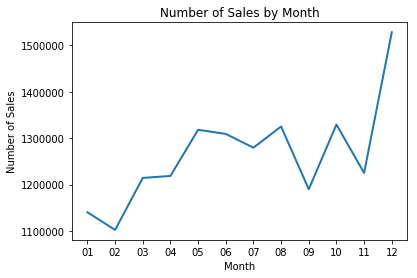

In [44]:
plt.xlabel('Month')
plt.ylabel('Number of Sales')
plt.title('Number of Sales by Month')
plt.plot(top_months.index.sort_values(), top_months.sort_index(), linewidth=2.0)
plt.show()

January corresponds to `01`, February to `02`, March to `03`, and so forth.

Here, we can see the top 5 months are December, October, August, May, and June, respectively. December appears to have the most sales by almost 300,000! Could this be due to Christmas, or winter break? I wonder what month and day liquor is ordered the most. Let's use a similar method chain to create a Month Day column.

In [11]:
#Here, we split the data from the right. This leaves us with the date formated as a list [MM/DD, YYYY]
sales['Month Day'] = sales['Date'].str.rsplit(pat='/', n=1).str[0]

In [46]:
top_month_day = sales['Month Day'].value_counts()
print(top_month_day.head(10))

12/26    88847
12/27    77786
12/18    74582
12/19    71979
12/28    68374
12/21    67501
06/27    66710
12/20    65842
05/23    63170
06/26    62967
Name: Month Day, dtype: int64


A whopping 7 out of the 10 days on which alcohol is ordered are in December and are close to Christmas time. Remember, this data is for orders that liquor stores place, not ones which customers buy from liquor stores. 

Interestingly, the day after Christmas is the most popular date. Could this be stores preparing for New Year's Eve parties? Two huge holidays in one month could explain why December has such a high number of orders.

Two other dates are close together: 6/26 and 6/27. These days are about a week before the 4th of July, so this isn't very surprising because people often have 4th of July parties. Finally, 5/23 is the last date in the top 10 days. This day is around the time Labor Day occurs, which is another popular holiday where people like to drink a lot. This data isn't too surprising, but it is interesting. It gives some interesting insight into why these months have the top 5 most sales.

Looking back at the data, another interesting trend is that sales appear to slow down after December before picking back up in the summer months. Do people drink so much that they decide to take a break after the holidays? Could it be due to a lack of holidays and good weather?

One final observation is the huge dip in sales in September. Why could this be? Perhaps it's because college students try to concentrate after returning to school?

## Which brands and types are most popular?

Which brand does Iowa love the most? What types of alcohol are ordered the most?

In [13]:
top_brands = sales['Item Description'].value_counts().head(10)
top_types = sales['Category Name'].value_counts().head(10)
print(top_brands)
print('\n' + '-'*40 + '\n')
print(top_types)

Black Velvet                     399191
Hawkeye Vodka                    359624
Five O'clock Vodka               254808
Captain Morgan Spiced Rum        189679
Seagrams 7 Crown Bl Whiskey      179084
Jack Daniels Old #7 Black Lbl    173773
Fireball Cinnamon Whiskey        165802
Jim Beam                         161342
Absolut Swedish Vodka 80 Prf     155336
Admiral Nelson Spiced Rum        152710
Name: Item Description, dtype: int64

----------------------------------------

Canadian Whiskies            1463741
Vodka 80 Proof               1255745
Straight Bourbon Whiskies     872294
Spiced Rum                    803275
American Vodkas               802649
Blended Whiskies              662249
Whiskey Liqueur               574291
Vodka Flavored                498464
Tequila                       431200
Flavored Rum                  413637
Name: Category Name, dtype: int64


Whiskey and vodka appear to be clear winners for the most popular type of alcohol, with rum falling closely behind.

Unsurprisingly, Black Velvet and Hawkeye Vodka beat out other brands by at least 10,000 orders. My own anecdotal evidence from working in a liquor store says that these two are the most popular probably due to their cheap price. However, always take anecdotal evidence with a grain of salt.

### Do some cities prefer certain liquors over others?

Let's look at two of the biggest college towns in Iowa: Ames and Iowa City. What is each town's favorite type of liquor?

In [14]:
top_type_ames = sales.loc[sales['City'] == 'Ames', 'Category Name'].value_counts()
top_type_ia_city = sales.loc[sales['City'] == 'Iowa City', 'Category Name'].value_counts()

print(top_type_ames.head(5))
print('\n' + '-'*40 + '\n')
print(top_type_ia_city.head(5))

Canadian Whiskies            32086
Vodka 80 Proof               30482
Straight Bourbon Whiskies    27841
Spiced Rum                   22410
American Vodkas              20035
Name: Category Name, dtype: int64

----------------------------------------

Vodka 80 Proof               39496
Straight Bourbon Whiskies    30689
Canadian Whiskies            27002
Spiced Rum                   22930
American Vodkas              22263
Name: Category Name, dtype: int64


Interesting! The two cities share the top 5 favorite types of alcohol, albeit in different orders. It also appears that whiskey is more popular in Ames and vodka is more popular in Iowa City. Let's do some more data cleaning before we come to that conclusion. We're going to import the regular expression module so we can easily count vodka and whiskey orders.

In [15]:
import re

In [16]:
# We use 'whisk' because some rows are 'Whiskies' and others are 'Whiskey'
vodka_ames = top_type_ames[top_type_ames.index.str.contains('vodka', flags=re.IGNORECASE, regex=True)].sum()
whiskey_ames = top_type_ames[top_type_ames.index.str.contains('whisk', flags=re.IGNORECASE, regex=True)].sum()

vodka_ia_city = top_type_ia_city[top_type_ia_city.index.str.contains('vodka', flags=re.IGNORECASE, regex=True)].sum()
whiskey_ia_city = top_type_ia_city[top_type_ia_city.index.str.contains('whisk', flags=re.IGNORECASE, regex=True)].sum()

print('Vodka in Ames: ' + str(vodka_ames))
print('Whiskey in Ames: ' + str(whiskey_ames) + '\n')

print('Vodka in Iowa City: ' + str(vodka_ia_city))
print('Whiskey in Iowa City: ' + str(whiskey_ia_city))

Vodka in Ames: 110124
Whiskey in Ames: 117962

Vodka in Iowa City: 134807
Whiskey in Iowa City: 119602


It looks like our initial observation stands true! Whiskey is slightly more popular than vodka in Ames from 2012-2018, and vodka is more popular than whiskey in Iowa City from 2012-2018.

# What's next?

This analysis barely scratched the surface of what is to be discovered in the data set. There are hundreds of other (much more complex) connections to be made with this data. Nonetheless, the connections made here were interesting and fun to examine.